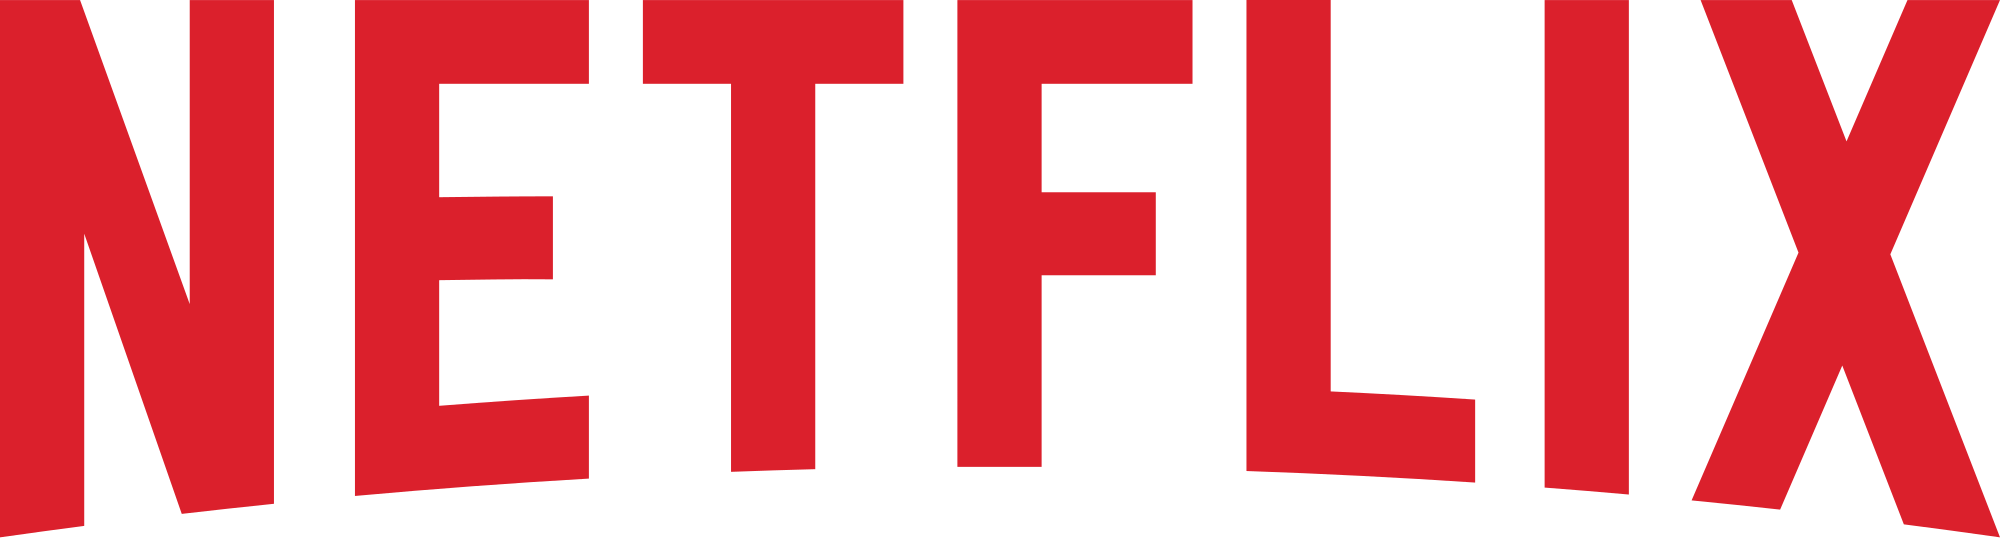

In [957]:
from IPython.display import Image 

Image("img/netflix_logo.png")

In [830]:
import numpy as np
import pandas as pd
from highcharts import Highchart
from IPython.display import HTML

In [831]:
from IPython.display import HTML
import random


def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    # bit of JS to permanently hide code in current cell (only when toggling next cell)
    js_hide_current = ''

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1, 2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current,
        toggle_text=toggle_text
    )

    return HTML(html)

In [832]:
def get_show(title):
    if ':' in title:
        return title.split(':')[0]
    else:
        return title


def convert_hours(time):
    return time.days * 24 + time.seconds/3600


def split_date(date):
    day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
               3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    return date.day, date.month, date.year, day_map[date.dayofweek]


def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [833]:
view_act = pd.read_csv('Content_Interaction/ViewingActivity.csv')
search_act = pd.read_csv('Content_Interaction/SearchHistory.csv')

In [834]:
view_act['Show'] = view_act['Title'].apply(get_show)
view_act['Duration'] = pd.to_timedelta(view_act['Duration'])
view_act['Start Time'] = pd.to_datetime(view_act['Start Time'])
view_act['day'], view_act['month'], view_act['year'], view_act['dayofweek'] = list(
    zip(*view_act['Start Time'].map(split_date)))
view_act['Start Time'] = view_act['Start Time'].dt.tz_localize(
    'utc').dt.tz_convert('US/Mountain')
view_act['Start Hour'] = view_act['Start Time'].dt.hour

## Dataset (First 10 entries of the table)

In [835]:
view_act.head(10)

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country,Show,day,month,year,dayofweek,Start Hour
0,Tony,2020-10-05 19:31:43-06:00,00:07:13,Autoplayed: user action: Unspecified;,Pokémon The Series: Indigo League: Season 1: S...,NaN,Sony PS4,00:08:09,00:08:09,US (United States),Pokémon The Series,6,10,2020,Tuesday,19
1,Tony,2020-10-05 17:45:09-06:00,00:43:11,NaN,Gilmore Girls: Season 4: Nag Hammadi Is Where ...,NaN,Sony PS4,00:43:11,00:43:11,US (United States),Gilmore Girls,5,10,2020,Monday,17
2,Tony,2020-10-05 17:28:29-06:00,00:16:08,Autoplayed: user action: Unspecified;,Gilmore Girls: Season 4: A Family Matter (Epis...,NaN,Sony PS4,00:43:08,00:43:08,US (United States),Gilmore Girls,5,10,2020,Monday,17
3,HijackerJo,2020-10-05 00:59:46-06:00,00:00:53,Autoplayed: user action: None;,Hart of Dixie: Season 1_hook_primary_16x9,HOOK,Roku Bryan-2 Set Top Box,00:00:53,00:00:53,US (United States),Hart of Dixie,5,10,2020,Monday,0
4,HijackerJo,2020-10-05 00:58:44-06:00,00:00:54,Autoplayed: user action: None;,Hart of Dixie: Season 1_hook_primary_16x9,HOOK,Roku Bryan-2 Set Top Box,00:00:54,Not latest view,US (United States),Hart of Dixie,5,10,2020,Monday,0
5,HijackerJo,2020-10-05 00:04:43-06:00,00:53:39,NaN,Ratched: Season 1: Mildred and Edmund (Episode 8),NaN,Roku Bryan-2 Set Top Box,00:57:18,00:57:18,US (United States),Ratched,5,10,2020,Monday,0
6,HijackerJo,2020-10-04 23:08:04-06:00,00:56:36,NaN,Ratched: Season 1: The Bucket List (Episode 7),NaN,Roku Bryan-2 Set Top Box,00:56:39,00:56:39,US (United States),Ratched,5,10,2020,Monday,23
7,Band,2020-10-04 22:35:08-06:00,00:00:01,NaN,Arrested Development: Season 4 Remix: Fateful ...,NaN,Roku Bryan-2 Set Top Box,00:00:07,00:00:07,US (United States),Arrested Development,5,10,2020,Monday,22
8,HijackerJo,2020-10-04 22:14:18-06:00,00:45:55,NaN,Ratched: Season 1: Got No Strings (Episode 6),NaN,Roku Bryan-2 Set Top Box,00:45:55,00:45:55,US (United States),Ratched,5,10,2020,Monday,22
9,HijackerJo,2020-10-04 22:14:07-06:00,00:00:07,Autoplayed: user action: None;,Season 1 Trailer 2: Ratched,TRAILER,Roku Bryan-2 Set Top Box,00:00:07,00:00:07,US (United States),Season 1 Trailer 2,5,10,2020,Monday,22


In [836]:
total_act_by_profile = view_act.groupby(
    'Profile Name').Duration.sum().sort_values(ascending=False)

chart = Highchart()

options = {
    'chart': {
        'type': 'column'
    },
    'title': {
        'text': 'Cumulative Watch Time (2014-2020)'
    },
    'subtitle': {
        'text': "Click column to see favorite shows"
    },
    'legend': {
        'enabled': False
    },
    'yAxis': {
        'title': {
            'text': 'Days'
        }
    },
    'xAxis': {
        'type': 'category'
    }
}

chart.set_dict_options(options)
# chart.set_options(
#    'xAxis', {'categories': total_act_by_profile.index.to_list()})
data = list()
for profile in total_act_by_profile.index:
    data.append({'y': total_act_by_profile[profile].days,
                 'name': profile, 'drilldown': profile, 'valueSuffix': 'test'})
# chart.add_data_set({'y':total_act_by_profile[profile].days, 'name':profile})#, 'drilldown':profile})
# print(data)
chart.add_data_set(data, 'column', 'watch time', colorByPoint=True)

fav_shows = view_act.groupby(['Profile Name', 'Show'])[
    'Duration'].sum().apply(convert_hours).unstack(level=0)
dd_data = list()
for profile in fav_shows.columns:
    top10 = fav_shows[profile].sort_values(ascending=False)[:10]
    data = [list(x) for x in zip(top10.index, (top10/24).to_list())]
    # print(profile)
    # print(data)
    chart.add_drilldown_data_set(data, 'column', profile, name=profile)

chart.add_JSsource("https://code.highcharts.com/6/modules/drilldown.js")
chart

In [837]:
watch_time_month = view_act.groupby(
    ['Profile Name', 'year', 'month']).Duration.sum().apply(convert_hours).unstack(level=0)

chart = Highchart()

options = {
    'plotOptions': {
        'line': {
            'marker': {
                'enabled': False
            }
        }
    },
    'title': {
        'text': 'Watch Time'
    },
    'yAxis': {
        'title': {
            'text': 'Hours'
        }
    },
    'tooltip': {
        'valueDecimals': 1,
        'valueSuffix': ' Hours'
    }
}
chart.set_dict_options(options)
chart.set_options('xAxis', {'categories': watch_time_month.index.to_list()})
for profile in watch_time_month.columns:
    chart.add_data_set(
        watch_time_month[profile].to_list(), series_type='line', name=profile)
chart

In [838]:
chart = Highchart()

options = {
    'title': {
        'text': 'Time of Day'
    },
    'chart': {
        'polar': True,
        'type': 'line'
    },
    'yAxis': {
        'gridLineInterpolation': 'polygon',
        'lineWidth': 0,
        'min': 0
    },
    'xAxis': {
        'tickmarkPlacement': 'on',
        'lineWidth': 0
    },
    'tooltip': {
        'shared': True
    }
}

chart.set_dict_options(options)
chart.set_options('xAxis', {'categories': ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM',
                                           '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
                                           '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']})
sum_pf_start = view_act.groupby(['Profile Name', 'Start Hour'])[
    'Start Time'].count().unstack(level=0)
normalized = sum_pf_start / sum_pf_start.max()
for profile in normalized.columns:
    chart.add_data_set(normalized[profile].to_list(), name=profile)

chart

In [839]:
sum_pf_start

Profile Name,Band,HijackerJo,Kids,Sarah,Tony
Start Hour,,,,,
0,301.0,331.0,NaN,346.0,1188.0
1,89.0,96.0,NaN,268.0,776.0
2,39.0,44.0,NaN,181.0,523.0
3,40.0,13.0,1.0,93.0,263.0
4,44.0,7.0,1.0,35.0,149.0
5,35.0,3.0,NaN,15.0,70.0
6,25.0,7.0,9.0,14.0,47.0
7,46.0,1.0,141.0,24.0,32.0
8,73.0,4.0,125.0,45.0,42.0


# Under Construction

In [840]:
dayofweek_mean = view_act.groupby(
    ['Profile Name', 'dayofweek']).Duration.sum().unstack(level=0)
#days = list(dayofweek_mean['dayofweek'].unique())
# dayofweek_mean
#tony_dayofweek_mean = dayofweek_mean[dayofweek_mean['Profile Name'] == 'Tony']
days = ['Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday', 'Saturday', 'Sunday']
dayofweek_mean = dayofweek_mean/dayofweek_mean.max()
data = list()
for ix in range(len(dayofweek_mean.columns)):
    for iy in reversed(range(len(dayofweek_mean.index))):
        print(ix, iy, dayofweek_mean.iat[iy, ix])
        data.append([ix, iy, dayofweek_mean.iat[iy, ix]])
print(data)

0 6 0.8286118178405658
0 5 0.9493433870977352
0 4 0.8889507897825789
0 3 1.0
0 2 0.9978534954805727
0 1 0.8030057021646776
0 0 0.9206776459652866
1 6 0.737274934531828
1 5 0.7701272407202095
1 4 0.5910534116964502
1 3 0.9848211198931845
1 2 1.0
1 1 0.8345254699998808
1 0 0.6569577069648598
2 6 0.7935155119533084
2 5 0.3408094878736058
2 4 0.47975587972610895
2 3 0.2975968761466937
2 2 0.5322355075223107
2 1 0.4648185714186808
2 0 1.0
3 6 0.8683454677353836
3 5 0.9063862058831229
3 4 0.9924702241957809
3 3 0.8906831270020497
3 2 1.0
3 1 0.9595599692255462
3 0 0.9001164598568194
4 6 0.4729196333163316
4 5 0.5630459693183995
4 4 0.4448933044688418
4 3 1.0
4 2 0.7734101835033892
4 1 0.7860054144000886
4 0 0.5189780954513039
[[0, 6, 0.8286118178405658], [0, 5, 0.9493433870977352], [0, 4, 0.8889507897825789], [0, 3, 1.0], [0, 2, 0.9978534954805727], [0, 1, 0.8030057021646776], [0, 0, 0.9206776459652866], [1, 6, 0.737274934531828], [1, 5, 0.7701272407202095], [1, 4, 0.5910534116964502], [1, 3

In [841]:
dayofweek_mean/dayofweek_mean.max()

Profile Name,Band,HijackerJo,Kids,Sarah,Tony
dayofweek,,,,,
Friday,0.920678,0.656958,1.000000,0.900116,0.518978
Monday,0.803006,0.834525,0.464819,0.959560,0.786005
Saturday,0.997853,1.000000,0.532236,1.000000,0.773410
Sunday,1.000000,0.984821,0.297597,0.890683,1.000000
Thursday,0.888951,0.591053,0.479756,0.992470,0.444893
Tuesday,0.949343,0.770127,0.340809,0.906386,0.563046
Wednesday,0.828612,0.737275,0.793516,0.868345,0.472920


In [856]:
chart = Highchart()


options = {
    'chart': {
        'type': 'heatmap'
    },
    'xAxis': {
        'categories': dayofweek_mean.columns.to_list()
    },
    'yAxis': {
        'categories': dayofweek_mean.index.to_list()
    },
    'colorAxis': {
        'min': 0,
        'minColor': '#0000ff',
        'maxColor': '#ff3300'
    }
}
chart.set_dict_options(options)
#chart.set_options('xAxis', {'categories': tony_dayofweek_mean['dayofweek'].to_list()})
chart.add_data_set(data, 'heatmap')
chart

In [843]:
view_act.groupby('Profile Name')[
    'Device Type'].value_counts().unstack(level=0).head(10)

Profile Name,Band,HijackerJo,Kids,Sarah,Tony
Device Type,,,,,
Apple iPad 2 WiFi,NaN,NaN,NaN,2.0,NaN
Apple iPad 4 WiFi,55.0,NaN,16.0,NaN,NaN
Apple iPad 6th Gen 9.7 (Wi-Fi) iPad,NaN,NaN,21.0,NaN,NaN
Apple iPad Air 3rd Gen (Wi-Fi),NaN,10.0,3.0,NaN,NaN
Apple iPad mini,1237.0,NaN,NaN,NaN,NaN
Chrome PC (Cadmium),62.0,1.0,NaN,NaN,NaN
DefaultWidevineAndroidPhone,16.0,NaN,NaN,NaN,NaN
DefaultWidevineAndroidPhone (samsung_SM-G928V),1.0,NaN,NaN,NaN,NaN
Edge (Cadmium),NaN,NaN,NaN,NaN,11.0


In [883]:
chart = Highchart
options = {
    'chart': {
        'type': 'column'
    },
    'title': {
        'text': 'Cumulative Watch Time (2014-2020)'
    },
    'subtitle': {
        'text': "Click column to see favorite shows"
    },
    'legend': {
        'enabled': False
    },
    'yAxis': {
        'title': {
            'text': 'Days'
        }
    },
    'xAxis': {
        'type': 'category'
    }
}
watch_sum_day = view_act.groupby(['Profile Name', 'day', 'month', 'year'])['Duration'].sum()
#watch_sum_day.groupby(['Profile Name', 'year']).mean()
watch_sum_day.apply(convert_hours).groupby('Profile Name').mean()

Profile Name
Band          1.270053
HijackerJo    2.412939
Kids          1.165976
Sarah         2.527987
Tony          2.586884
Name: Duration, dtype: float64

In [844]:
import requests
import json

In [845]:
api_key = 'e1d90e9d7e47f9e2100f0edb6eae3c82'

In [931]:
search_url = 'https://api.themoviedb.org/3/search/multi'
tv_details_url = 'https://api.themoviedb.org/3/tv'

In [847]:
parameters = {'api_key':api_key,
              'query':'',
              'page':1}

In [892]:
parameters['query'] = view_act.loc[1].Show
parameters

{'api_key': 'e1d90e9d7e47f9e2100f0edb6eae3c82',
 'query': 'Gilmore Girls',
 'page': 1}

In [893]:
response = requests.get(search_url, params=parameters)
print(response.status_code)
response.url

200


'https://api.themoviedb.org/3/search/multi?api_key=e1d90e9d7e47f9e2100f0edb6eae3c82&query=Gilmore+Girls&page=1'

In [921]:
print(json.dumps(response.json(), indent=4))

{
    "page": 1,
    "results": [
        {
            "backdrop_path": "/8RvnqnUNO1s9uFUQBqqRZmIDhZr.jpg",
            "first_air_date": "2000-10-05",
            "genre_ids": [
                35,
                18
            ],
            "id": 4586,
            "media_type": "tv",
            "name": "Gilmore Girls",
            "origin_country": [
                "US"
            ],
            "original_language": "en",
            "original_name": "Gilmore Girls",
            "overview": "Set in the charming town of Stars Hollow, Connecticut, the series follows the captivating lives of Lorelai and Rory Gilmore, a mother/daughter pair who have a relationship most people only dream of.",
            "popularity": 40.984,
            "poster_path": "/dSS7XoqmNxMebyVbEGBY0HWrReA.jpg",
            "vote_average": 7.7,
            "vote_count": 337
        },
        {
            "backdrop_path": "/gGnNflhU2dLqL3LtfDHTisainWx.jpg",
            "first_air_date": "2016-11-25",
    

In [948]:
idn = response.json()['results'][0]['id']
detail_parameters = {'api_key': api_key}
tv_details_url = tv_details_url + '/{}'.format(idn)
detail_rsp = requests.get(tv_details_url, params=detail_parameters)

In [954]:
print(detail_rsp.url)
print(json.dumps(detail_rsp.json(), indent=4))

https://api.themoviedb.org/3/tv/4586?api_key=e1d90e9d7e47f9e2100f0edb6eae3c82
{
    "backdrop_path": "/8RvnqnUNO1s9uFUQBqqRZmIDhZr.jpg",
    "created_by": [
        {
            "id": 1222946,
            "credit_id": "525772b7760ee36aaa4c1bdc",
            "name": "Amy Sherman-Palladino",
            "gender": 1,
            "profile_path": null
        }
    ],
    "episode_run_time": [
        44
    ],
    "first_air_date": "2000-10-05",
    "genres": [
        {
            "id": 35,
            "name": "Comedy"
        },
        {
            "id": 18,
            "name": "Drama"
        }
    ],
    "homepage": "http://www2.warnerbros.com/gilmoregirls/",
    "id": 4586,
    "in_production": false,
    "languages": [
        "en"
    ],
    "last_air_date": "2007-05-15",
    "last_episode_to_air": {
        "air_date": "2007-05-15",
        "episode_number": 22,
        "id": 331242,
        "name": "Bon Voyage",
        "overview": "Rory lands her dream job as a political repo

In [890]:
view_act.head(50)

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country,Show,day,month,year,dayofweek,Start Hour
0,Tony,2020-10-05 19:31:43-06:00,00:07:13,Autoplayed: user action: Unspecified;,Pokémon The Series: Indigo League: Season 1: S...,NaN,Sony PS4,00:08:09,00:08:09,US (United States),Pokémon The Series,6,10,2020,Tuesday,19
1,Tony,2020-10-05 17:45:09-06:00,00:43:11,NaN,Gilmore Girls: Season 4: Nag Hammadi Is Where ...,NaN,Sony PS4,00:43:11,00:43:11,US (United States),Gilmore Girls,5,10,2020,Monday,17
2,Tony,2020-10-05 17:28:29-06:00,00:16:08,Autoplayed: user action: Unspecified;,Gilmore Girls: Season 4: A Family Matter (Epis...,NaN,Sony PS4,00:43:08,00:43:08,US (United States),Gilmore Girls,5,10,2020,Monday,17
3,HijackerJo,2020-10-05 00:59:46-06:00,00:00:53,Autoplayed: user action: None;,Hart of Dixie: Season 1_hook_primary_16x9,HOOK,Roku Bryan-2 Set Top Box,00:00:53,00:00:53,US (United States),Hart of Dixie,5,10,2020,Monday,0
4,HijackerJo,2020-10-05 00:58:44-06:00,00:00:54,Autoplayed: user action: None;,Hart of Dixie: Season 1_hook_primary_16x9,HOOK,Roku Bryan-2 Set Top Box,00:00:54,Not latest view,US (United States),Hart of Dixie,5,10,2020,Monday,0
5,HijackerJo,2020-10-05 00:04:43-06:00,00:53:39,NaN,Ratched: Season 1: Mildred and Edmund (Episode 8),NaN,Roku Bryan-2 Set Top Box,00:57:18,00:57:18,US (United States),Ratched,5,10,2020,Monday,0
6,HijackerJo,2020-10-04 23:08:04-06:00,00:56:36,NaN,Ratched: Season 1: The Bucket List (Episode 7),NaN,Roku Bryan-2 Set Top Box,00:56:39,00:56:39,US (United States),Ratched,5,10,2020,Monday,23
7,Band,2020-10-04 22:35:08-06:00,00:00:01,NaN,Arrested Development: Season 4 Remix: Fateful ...,NaN,Roku Bryan-2 Set Top Box,00:00:07,00:00:07,US (United States),Arrested Development,5,10,2020,Monday,22
8,HijackerJo,2020-10-04 22:14:18-06:00,00:45:55,NaN,Ratched: Season 1: Got No Strings (Episode 6),NaN,Roku Bryan-2 Set Top Box,00:45:55,00:45:55,US (United States),Ratched,5,10,2020,Monday,22
9,HijackerJo,2020-10-04 22:14:07-06:00,00:00:07,Autoplayed: user action: None;,Season 1 Trailer 2: Ratched,TRAILER,Roku Bryan-2 Set Top Box,00:00:07,00:00:07,US (United States),Season 1 Trailer 2,5,10,2020,Monday,22
